In [4]:
using SeisPlot,PyPlot, Printf

## 1) Test CGLS with EXPLICIT OPERATOR 

In [5]:
function cgls(A, y, x0, tol, max_iter)
# min_x ||A x-y||_2^2 

    m, n = size(A)
    x = x0
    r = A' * (y - A * x)
    p = r
    rsold = r' * r

    for i in 1:max_iter
        Ap = A * p
        alpha = rsold / (Ap' * Ap)
        x = x + alpha * p
        r = r - alpha * A' * Ap
        rsnew = r' * r
        if sqrt(rsnew) < tol
            break
        end
        p = r + (rsnew / rsold) * p
        rsold = rsnew
    end

    return x
end

cgls (generic function with 1 method)

In [6]:
# Testing CGLS with Explicit A. 

A = randn(20,3)
x = randn(3)
y = A*x+0.001*randn(20)
x0 = zeros(3)
tol = 0.0001
max_iter = 3


x1 = cgls(A, y, x0, tol, 20)


x2 = (A'*A)\(A'y)
k=1
@printf("    True      Estimated\n")
for k in 1:3
@printf("   %7.4f     %7.4f \n", x1[k],x2[k])
end

    True      Estimated
    1.7556      1.7556 
   -0.8735     -0.8735 
    0.7247      0.7247 


### 2) CGLS Implicit for demigration and migration Opertors 

In [7]:
function cgls_Implicit(y, x0, tol, max_iter, ntraces, s, rec, nx, nz, dx, dz, nt, dt, v)
# min_x ||A x-y||_2^2 Implicit. This code is not recyclable because it is 
# designed for the specific operators used in PSTM with demigra and migra operators. 

    x = x0
    tmp = y .- demigra(ntraces,s,rec,nx,nz,dx,dz,nt,dt,v,x)
    r = migra(ntraces,s,rec,nx,nz,dx,dz,nt,dt,v,tmp)
    p = r
    rsold = sum(r.*r)

    for i in 1:max_iter
        Ap = demigra(ntraces,s,rec,nx,nz,dx,dz,nt,dt,v,p)
        alpha = rsold / sum(Ap.* Ap)
        x = x + alpha * p
        r = r - alpha * migra(ntraces,s,rec,nx,nz,dx,dz,nt,dt,v,Ap) # 
        rsnew = sum(r.*r)
        if sqrt(rsnew) < tol
            break
        end
        p = r + (rsnew / rsold) * p
        rsold = rsnew
    end

    return x
end

cgls_Implicit (generic function with 1 method)

### 3) Dot product test to ensure migration and demigration functions behave like L' and L

Born / Kirchoff PSTM Example

- $L$ Demigration (modelling) operator
- $L'$: Migration (imaging) operator

Test numertically that 
$$<Lx,y> = <L'y,x>$$



In [8]:
nx = 200; nz = 200
dx = 10.; dz = 10.
nt = 1200; dt = 0.002

Lx = (nx-1)*dx
Lz = (nz-1)*dz

# Prepare a simple geometry by computing sources and receiver positions
ns = 10 
nr = 20
ntraces = nr*ns
s = zeros(ntraces)
r = zeros(ntraces)

k = 1
 for is = 1:ns
   for ir = 1:nr
    s[k] = 10.0 + (0.8*Lx-10.0)*(is-1)/(ns-1)
    r[k] = 14.0 + (0.9*Lx-14.0)*(ir-1)/(nr-1)
    k = k + 1
  end
end
 v = ones(nz,nx)*1000; 

 m1 = randn(nz,nx);      d1 = demigra(ntraces,s,r,nx,nz,dx,dz,nt,dt,v,m1)  # L m1
 d2 = randn(nt,ntraces); m2 =   migra(ntraces,s,r,nx,nz,dx,dz,nt,dt,v,d2)  # L'd2

aux1 = d1.*d2;
aux2 = m1.*m2;
dot1 = sum(aux1[:])
dot2 = sum(aux2[:]) 

println("True if we pass the dot product test --> ", abs(dot1-dot2)<1.0e-10) 


True if we pass the dot product test --> true


### 4) Test code with inverse problem crime. 

- First we use a model to generate
data via the demigration operator. Then, we add noise todata and then we use the adjoint to recover the image.
Finally, we use LS migration to find the image that fits the data. The LS migration is iteratively computed
via CGLS. 

In [9]:
 ns = 4              # 4 sources
 nr = 100            # 100 receivers
 ntraces = ns*nr     # Total number of traces to model 
 nt = 1000
 dt = 2/1000.0
 nx = 200; dx = 10; Lx = (nx-1)*dx
 nz = 300; dz = 10; Lz = (nz-1)*dz;
  v = ones(nz,nx)*1900

 # Prepare a simple geometry by computing sources and receiver positions

 s = zeros(ntraces)
 r = zeros(ntraces)
 
 k = 1
  for is = 1:ns
    for ir = 1:nr
     s[k] = 10.0 + (0.8*Lx-10.0)*(is-1)/(ns-1)
     r[k] = 14.0 + (0.9*Lx-14.0)*(ir-1)/(nr-1)
     k = k + 1
   end
 end

 m_true = zeros(nz,nx)
  n1=100
  m_true[100,1:n1]    .=1.0;      m_true[110,n1:end] .=1.0
  m_true[120,1:n1+20] .=-1.0;     m_true[130,n1+20:end] .=-1.0
  m_true[140,1:n1+40] .=1.0;      m_true[150,n1+40:end] .=1.0

d      = demigra(ntraces,s,r,nx,nz,dx,dz,nt,dt,v,m_true)
m_adj  = migra(ntraces,s,r,nx,nz,dx,dz,nt,dt,v,d)
m_adj  = m_adj/maximum(m_adj)
m_cgls = cgls_Implicit(d, zeros(size(m_true)), 0.001,10,ntraces,s,r,nx,nz,dx,dz,nt,dt,v);



## Now plot results obtained via test with inverse problem crime

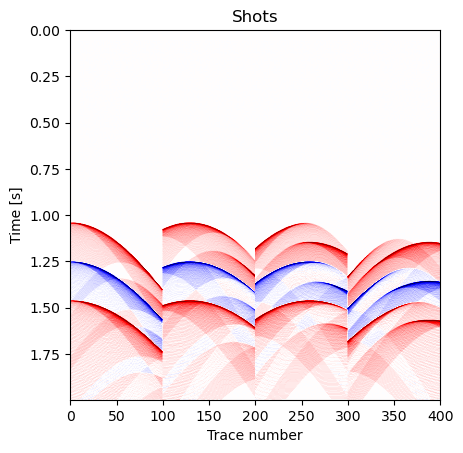

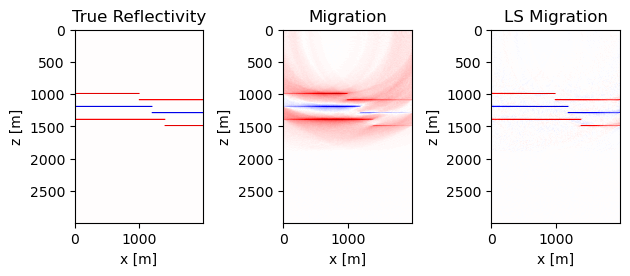

In [10]:
dmax = 0.4*maximum(d)
figure(1)
tmax = dt*(nt-1)
imshow(d,vmin=-dmax,vmax=dmax,extent=[0,ntraces,tmax,0],aspect=200,cmap="seismic")
xlabel("Trace number"); ylabel("Time [s]");title("Shots")
figure(2)
E = [0,(nx-1)*dx,(nz-1)*dz,0]

subplot(131);imshow(m_true,vmin=-1,vmax=1,cmap="seismic",extent=E )
title("True Reflectivity");xlabel("x [m]");ylabel("z [m]")

subplot(132);imshow(m_adj, vmin=-1,vmax=1,cmap="seismic",extent=E)
title("Migration");xlabel("x [m]");ylabel("z [m]")

subplot(133);imshow(m_cgls,vmin=-1,vmax=1,cmap="seismic",extent=E)
title("LS Migration");xlabel("x [m]");ylabel("z [m]")

tight_layout()

### Functions for migration and demigration 

In [11]:
"""
    demigra(ntraces,s,r,nx,nz,dx,dz,nt,dt,v,m)

Demigration PSTM operator 
"""
function demigra(ntraces,s,r,nx,nz,dx,dz,nt,dt,v,m)
# Program for simple demigration d = L m
    d = zeros(nt,ntraces)
 for k = 1:ntraces
    for ix = 1:nx
       for iz = 1:nz
            dr = ((ix-1)*dx-r[k])^2+((iz-1)*dz)^2; dr =sqrt(dr)
            ds = ((ix-1)*dx-s[k])^2+((iz-1)*dz)^2; ds =sqrt(ds)
            time = (dr+ds)/v[iz,ix]
            it = floor(Int,time/dt+1)
            if (  it<nt )
               d[it,k] = d[it,k] + m[iz,ix]
            end
        end
    end
end
return d
end

demigra (generic function with 1 method)

In [12]:
"""
    migra(ntraces,s,r,nx,nz,dx,dz,nt,dt,v,d)

migration PSTM 
"""
function migra(ntraces,s,r,nx,nz,dx,dz,nt,dt,v,d)
    # Program for simple migration ma = L' m
        ma = zeros(nz,nx)
 for k = 1:ntraces
    for ix = 1:nx
       for iz = 1:nz
            dr = ((ix-1)*dx-r[k])^2+((iz-1)*dz)^2; dr =sqrt(dr)
            ds = ((ix-1)*dx-s[k])^2+((iz-1)*dz)^2; ds =sqrt(ds)
            time = (dr+ds)/v[iz,ix]
            it = floor(Int,time/dt+1)  # Assigned nearest integer 
            
            if (  it<nt )
             
         ma[iz,ix] = ma[iz,ix] +  d[it,k]
            end
        end
    end
end
    return ma
end

migra (generic function with 1 method)